# Importing and Cleaning

In [ ]:
# Importing
# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# Math and data reading
import numpy as np
import pandas as pd
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree
# Model Selection and
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
# Rebalancing
from sklearn.utils import resample

# quindi vai su runtime, cambia tipo di runtime e metti acceleratore hardware

In [ ]:
# Reading Data
train = pd.read_csv('/content/drive/MyDrive/Datasets/Binary_Classification_of_Machine_Failures/playground-series-s3e17/train.csv')
original = pd.read_csv('/content/drive/MyDrive/Datasets/Binary_Classification_of_Machine_Failures/playground-series-s3e17/machine failure.csv')

In [ ]:
count = (train["Machine failure"] == 1).sum()
print(count)

2148


In [ ]:
from sklearn.exceptions import DataConversionWarning
# Cleaning data

# Cheking for duplicate rows
def drop_missing_rows(df,name):
  if df.isnull().any().any():
    print("Missing values found in the dataframe.")
    newdata = df.dropna(axis=0)
    dropped_rows = len(newdata) - len(df.dropna())
    print(f"Dropped {dropped_rows} rows in the dataframe {name}")
  else:
    print(f"No missing values found in the dataframe {name}.")
    newdata = df.copy()
  return newdata

  # Checking for missin value, if yes they will be dropped
def count_duplicate_rows(df,name):
  duplicate_rows = df[df.duplicated()]
  if not duplicate_rows.empty:
    count = len(duplicate_rows)
    print(f"Number of duplicate rows found in the dataframe {name}: {count}.")
  else:
     print(f"No duplicate rows found in the dataframe {name}.")
  return df

def cleaningAndEncoding(data,name):
  if name=="Original":
    newdata = data.drop(columns='UDI', inplace=False)
  else:
    newdata = data.drop(columns='id', inplace=False)
  newdata = newdata.drop(columns='Product ID', inplace=False)
  newdata = drop_missing_rows(newdata,name)
  newdata = count_duplicate_rows(newdata,name)


  # Move Machine failure at the last column
  y = newdata.pop("Machine failure")                        # Rimuovi la colonna dal DataFrame
  newdata.insert(len(newdata.columns), "Machine failure", y)  # Inserisci la colonna nella nuova posizione
  newdata = newdata.to_numpy()

  # Divding features from target
  Xtot = newdata[:,range(0,10)]
  Ytot = newdata[:,11].astype('int')

  # One hot encoding

  # Crea un'istanza di OneHotEncoder
  encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

  type_column_index = 0
  type_column= Xtot[:,type_column_index].reshape(-1, 1)
  type_column_encoded = encoder.fit_transform(type_column)
  Xtot_encoded = np.hstack((Xtot[:, :type_column_index], type_column_encoded, Xtot[:, type_column_index+1:]))

  #encoded_columns = encoder.get_feature_names_out()
  return Xtot_encoded,Ytot
#np.set_printoptions(threshold=np.inf)
#print(encoded_columns)

# Decision Tree Classifier

In [ ]:
# DecisionTreeClassifier
X_train_cleaned,Y_train_cleaned = cleaningAndEncoding(train,'train')
# Dividing Train and Set
X_train, X_test, Y_train, Y_test = train_test_split(X_train_cleaned, Y_train_cleaned, train_size = 0.85, random_state=42)
# Define the hyperparameters to tune
grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
# Create metrics
scoringRecall = make_scorer(recall_score)
scoringROC = make_scorer(roc_auc_score, greater_is_better=True)
# Create an instance of the DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11)
# Create GridSearchCV object with the classifier and hyperparameter grid
Hyperparameter = GridSearchCV(estimator = dtc,
                              param_grid = grid,
                              cv = 5,
                              scoring = scoringRecall
                              )
# Fit the GridSearchCV object to the training data
Hyperparameter.fit(X_train, Y_train)
# Creating the optimum DTC
OptimDtc = DecisionTreeClassifier(criterion = Hyperparameter.best_params_['criterion'],
               max_depth = Hyperparameter.best_params_['max_depth'],
               min_samples_split = Hyperparameter.best_params_['min_samples_split'],
               min_samples_leaf = Hyperparameter.best_params_['min_samples_leaf'],
               )
OptimDtc.fit(X_train,Y_train)
Y_predict = OptimDtc.predict(X_test)
# Print the best hyperparameters found
print("Best Hyperparameters:", Hyperparameter.best_params_)
print("Best Roc_auc accuracy", Hyperparameter.best_score_)




No missing values found in the dataframe train.
Number of duplicate rows found in the dataframe train: 1134.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Roc_auc accuracy 0.7734397109739575


Recall is: 0.7846153846153846


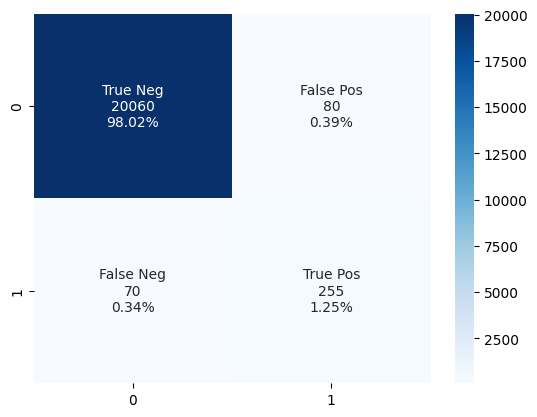

In [ ]:
# Confusion Matrix
Y_predict = OptimDtc.predict(X_test)
cf_matrix = confusion_matrix(Y_test,Y_predict)
group_names = ['True Neg','False Pos','False Neg','True Pos']
# Creating the labels
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Print Confusion matrix

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
print("Recall is: " + str(((cf_matrix[1,1])/(cf_matrix[1,1]+cf_matrix[1,0]))))

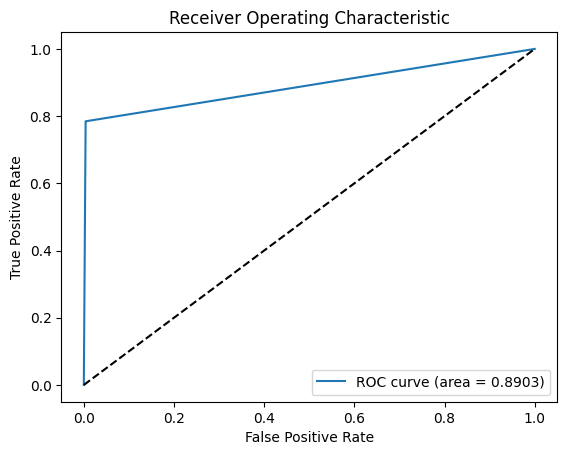

[1. 0. 0. ... 0. 0. 0.]


In [ ]:
# ROC Receiver operating Characteristic
Y_probs = OptimDtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)
roc_auc = auc(fpr, tpr)
# Traccia la curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Line of a random choice
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()




print(Y_probs)

In [ ]:
# Plotting the decision tree

feature_names = list(train.columns)
fig = plt.figure(figsize=(50,50))
plot_tree(OptimDtc, feature_names=feature_names, filled=True, rounded=True, class_names=['0', '1'],fontsize=10)
plt.savefig("decision_tree.png", dpi=300)
plt.show()


# Random Forest

In [ ]:
# Random Forest
X_train_cleaned,Y_train_cleaned = cleaningAndEncoding(train,'train')
# Dividing Train and Set
X_train, X_test, Y_train, Y_test = train_test_split(X_train_cleaned, Y_train_cleaned, train_size = 0.85, random_state=42)
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameters to tune
rf_grid = {
    'n_estimators': [100],  # Numero di alberi nella foresta
    'max_depth': [5, 10, 12],  # Profondità massima degli alberi
    'min_samples_split': [2, 3, 5],  # Numero minimo di campioni richiesti per suddividere un nodo interno
    'min_samples_leaf': [1, 2, 3],  # Numero minimo di campioni richiesti in una foglia
}

# Create metrics
scoringRecall = make_scorer(recall_score)
scoringROC = make_scorer(roc_auc_score, greater_is_better=True)

# Create GridSearchCV object with the classifier and hyperparameter grid
rf_hyperparameter = GridSearchCV(estimator=rf, param_grid=rf_grid, cv=5, scoring=scoringROC)

# Fit the GridSearchCV object to the training data
rf_hyperparameter.fit(X_train, Y_train)

# Creating the optimum Random Forest model
optimal_rf = RandomForestClassifier(random_state=42, **rf_hyperparameter.best_params_)
optimal_rf.fit(X_train, Y_train)
rf_y_pred = optimal_rf.predict(X_test)
print("Best Random Forest Hyperparameters:", rf_hyperparameter.best_params_)
print("Best Random Forest Score", rf_hyperparameter.best_score_)


No missing values found in the dataframe train.
Number of duplicate rows found in the dataframe train: 1134.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<Axes: >

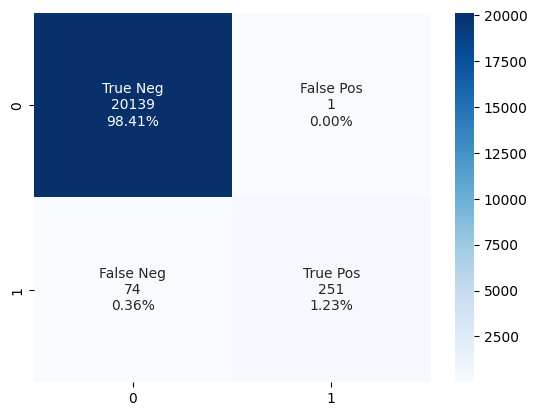

In [ ]:
# Confusion Matrix
Y_predict = optimal_rf.predict(X_test)
cf_matrix = confusion_matrix(Y_test,Y_predict)
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Creating the labels
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Print Confusion matrix
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

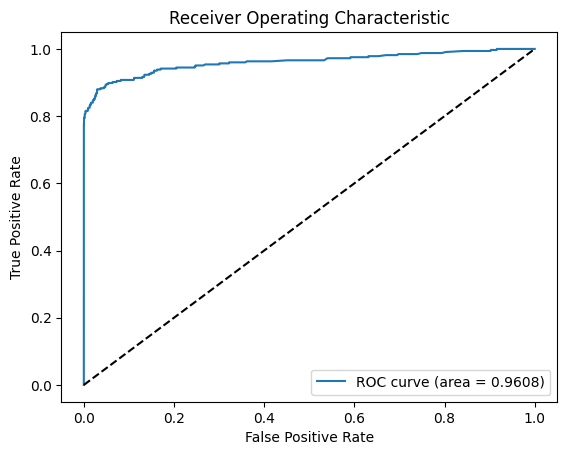

In [ ]:
# ROC Receiver operating Characteristic
Y_probs = optimal_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)
roc_auc = auc(fpr, tpr)
# Traccia la curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linea di riferimento per una classificazione casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Gradient Boosting

In [ ]:
# Gradient Boosting
X_train_cleaned,Y_train_cleaned = cleaningAndEncoding(train,'train')
# Dividing Train and Set
X_train, X_test, Y_train, Y_test = train_test_split(X_train_cleaned, Y_train_cleaned, train_size = 0.85, random_state=42)

gb = GradientBoostingClassifier(random_state=42)

# Define the hyperparameters to tune
gb_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5, 7],
}
# Create metrics
scoringRecall = make_scorer(recall_score)
scoringROC = make_scorer(roc_auc_score, greater_is_better=True)

# Create GridSearchCV object with the classifier and hyperparameter grid
gb_hyperparameter = GridSearchCV(estimator=gb, param_grid=gb_grid, cv=5, scoring=scoringROC)

# Fit the GridSearchCV object to the training data
gb_hyperparameter.fit(X_train, Y_train)

# Creating the optimum Gradient Boosting model
optimal_gb = GradientBoostingClassifier(random_state=42, **gb_hyperparameter.best_params_)
optimal_gb.fit(X_train, Y_train)
gb_y_pred = optimal_gb.predict(X_test)
print("Gradient Boosting scoring:", gb_hyperparameter.best_score_)
print("Best Gradient Boosting Hyperparameters:", gb_hyperparameter.best_params_)
#Best Gradient Boosting Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

No missing values found in the dataframe train.
Number of duplicate rows found in the dataframe train: 1156.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Gradient Boosting AUC: 0.889056985715377
Best Gradient Boosting Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [ ]:
# Confusion Matrix
Y_predict = optimal_gb.predict(X_test)
cf_matrix = confusion_matrix(Y_test,Y_predict)
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Creating the labels
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Print Confusion matrix
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

NameError: ignored

# Show the imbalance

No missing values found in the dataframe train.
Number of duplicate rows found in the dataframe train: 1156.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(




Xtot_cleaned

Total number of istances ended WELL 134281
Total number of istances ended FAIL 2148

Total istances: 136429


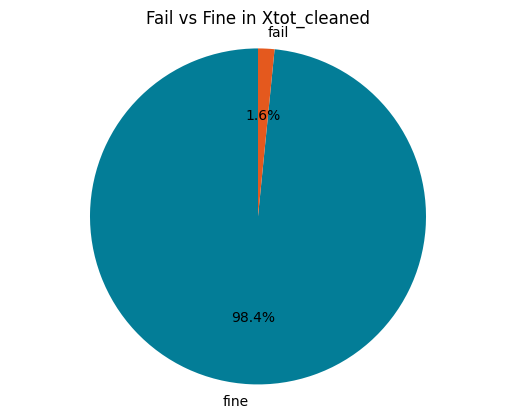

No missing values found in the dataframe Original.
No duplicate rows found in the dataframe Original.


Xtot_original_cleaned

Total number of istances ended WELL 9661
Total number of istances ended FAIL 339

Total istances: 10000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


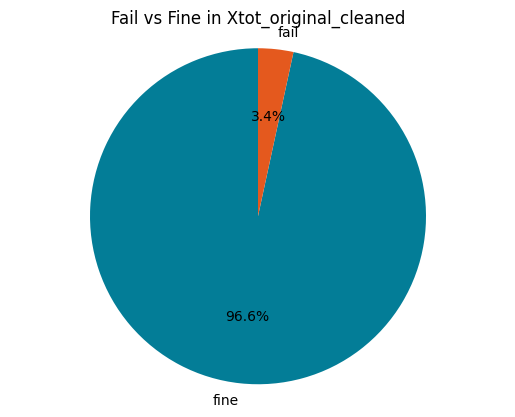

In [ ]:
def piechart(dataset,name):
  print("\n\n"+ name)
  nfine = (dataset.iloc[:,12]==0 ).sum()
#
  nfails = (dataset.iloc[:,12]==1 ).sum()
#  nfails = (dataset[dataset.iloc[:,12]==1 ]).sum()
  print("\nTotal number of istances ended WELL " + str(nfine) )
  print("Total number of istances ended FAIL " + str(nfails)+ "\n")
  print("Total istances: " + str(nfails+nfine))
  labels = ['fine' , 'fail']
  sizes = [nfine, nfails]
  colors = ['#037d97', '#E4591E']
  plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
  plt.axis('equal')
  plt.title('Fail vs Fine in '+ name)
  plt.show()
# Train
X_train_cleaned,Y_train_cleaned = cleaningAndEncoding(train,'train')
Xtot_cleaned = np.concatenate((X_train_cleaned, Y_train_cleaned.reshape(-1, 1)), axis=1)
Xtot_cleaned = pd.DataFrame(Xtot_cleaned)
piechart(Xtot_cleaned,'Xtot_cleaned')
# Original
X_original_cleaned,Y_original_cleaned = cleaningAndEncoding(original,'Original')
Xtot_original_cleaned = np.concatenate((X_original_cleaned, Y_original_cleaned.reshape(-1, 1)), axis=1)
Xtot_original_cleaned = pd.DataFrame(Xtot_original_cleaned)
piechart(Xtot_original_cleaned,'Xtot_original_cleaned')

#piechart(original,'ORIGINAL')
#piechart(train,'TRAIN')

# Look how are distribuited the data
#train.describe().T\
#        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
#        .background_gradient(subset=['std'], cmap='Blues')\
#        .background_gradient(subset=['50%'], cmap='BuGn')

# Undersampling

No missing values found in the dataframe train.
Number of duplicate rows found in the dataframe train: 1156.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(




train_UnderBalanced

Total number of istances ended WELL 1823
Total number of istances ended FAIL 1823

Total istances: 3646


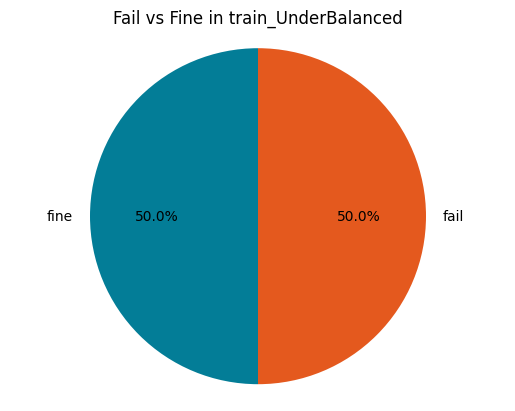

In [ ]:
## try to balance, Underbalancing
from sklearn.utils import resample

# Balancing training
X_train_cleaned,Y_train_cleaned = cleaningAndEncoding(train,'train')

# Dividing Train and Set
X_train, X_test, Y_train, Y_test = train_test_split(X_train_cleaned, Y_train_cleaned, train_size = 0.85, random_state=42)
Xtot = np.concatenate((X_train, Y_train.reshape(-1, 1)), axis=1)
Xtot_OverBalanced = pd.DataFrame(Xtot)

# Separare i dati delle due classi
majority_class = Xtot_OverBalanced[Y_train == 0]
minority_class = Xtot_OverBalanced[Y_train == 1]
# Eseguire l'undersampling sulla classe maggioritaria
undersampled_majority = resample(majority_class,
                                 replace=False,  # campioni senza sostituzione
                                 n_samples=len(minority_class),  # numero di campioni
                                                                 # pari alla classe minoritaria
                                 random_state=42)

# Unire i dati delle due classi bilanciate
train_UnderBalanced = np.concatenate([undersampled_majority, minority_class])
X_train_UnderBalanced = train_UnderBalanced[:,range(0,14)]
Y_train_UnderBalanced = train_UnderBalanced[:,14].astype('int')
train_UnderBalanced = pd.DataFrame(train_UnderBalanced)

# look the balance
piechart(train_UnderBalanced,'train_UnderBalanced')

In [ ]:
# DecisionTreeClassifier
# Define the hyperparameters to tune
grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create an instance of the DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11)

# Create GridSearchCV object with the classifier and hyperparameter grid
Hyperparameter = GridSearchCV(estimator = dtc,
                              param_grid = grid,
                              cv = 5,
                              scoring = 'roc_auc')

# Fit the GridSearchCV object to the training data
Hyperparameter.fit(X_train_UnderBalanced, Y_train_UnderBalanced)

# Creating the optimum DTC
# OptimDtc = Hyperparameter.best_estimator_
OptimDtc = DecisionTreeClassifier(criterion = Hyperparameter.best_params_['criterion'],
               max_depth = Hyperparameter.best_params_['max_depth'],
               min_samples_split = Hyperparameter.best_params_['min_samples_split'],
               min_samples_leaf = Hyperparameter.best_params_['min_samples_leaf'],
               )

OptimDtc.fit(X_train,Y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", Hyperparameter.best_params_)
print("Best Roc_auc accuracy", Hyperparameter.best_score_)
print("-------------------------------------")
print("Test Accuracy:", OptimDtc.score(X_test, Y_test))

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Roc_auc accuracy 0.8714440972392354
-------------------------------------
Test Accuracy: 0.9962863425360371


<Axes: >

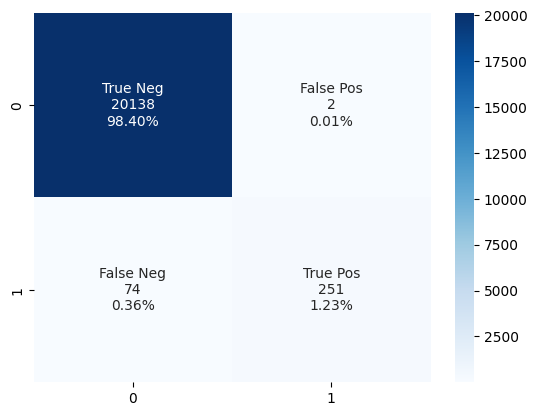

In [ ]:
# Confusion Matrix
Y_predict = OptimDtc.predict(X_test)
cf_matrix = confusion_matrix(Y_test,Y_predict)
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Creating the labels
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Print Confusion matrix
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Oversampling

No missing values found in the dataframe train.
Number of duplicate rows found in the dataframe train: 1156.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(




Xtot_OverBalanced

Total number of istances ended WELL 114141
Total number of istances ended FAIL 114141

Total istances: 228282


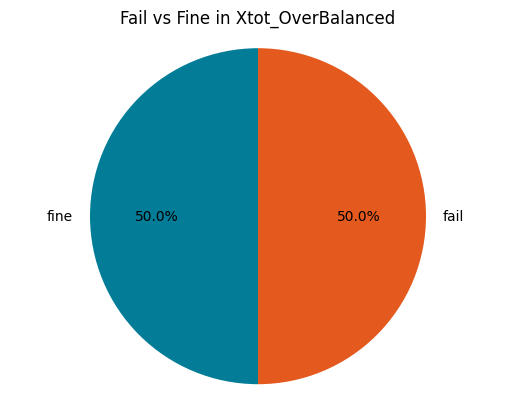

In [ ]:
from imblearn.over_sampling import SMOTE

X_train_cleaned,Y_train_cleaned = cleaningAndEncoding(train,'train')

# Dividing Train and Set
X_train, X_test, Y_train, Y_test = train_test_split(X_train_cleaned, Y_train_cleaned, train_size = 0.85, random_state=42)

# Creare un'istanza di SMOTE
smote = SMOTE(random_state=42)

# Applicare l'oversampling solo al train
X_train_over_balanced, Y_train_over_balanced = smote.fit_resample(X_train, Y_train)

train_OverBalanced = np.concatenate((X_train_over_balanced, Y_train_over_balanced.reshape(-1, 1)), axis=1)
train_OverBalanced = pd.DataFrame(train_OverBalanced)
#print(Xtot_OverBalanced.columns.tolist())
piechart(train_OverBalanced,'train_OverBalanced')

In [ ]:
#DecisionTreeClassifier


# Define the hyperparameters to tune
grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create an instance of the DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11)

# Create GridSearchCV object with the classifier and hyperparameter grid
Hyperparameter = GridSearchCV(estimator = dtc,
                              param_grid = grid,
                              cv = 5,
                              scoring = 'roc_auc')

# Fit the GridSearchCV object to the training data
Hyperparameter.fit(X_train_over_balanced, Y_train_over_balanced)

# Creating the optimum DTC
# OptimDtc = Hyperparameter.best_estimator_
OptimDtc = DecisionTreeClassifier(criterion = Hyperparameter.best_params_['criterion'],
               max_depth = Hyperparameter.best_params_['max_depth'],
               min_samples_split = Hyperparameter.best_params_['min_samples_split'],
               min_samples_leaf = Hyperparameter.best_params_['min_samples_leaf'],
               )

OptimDtc.fit(X_train_over_balanced,Y_train_over_balanced)

# Print the best hyperparameters found
print("Best Hyperparameters:", Hyperparameter.best_params_)
print("Best Roc_auc accuracy", Hyperparameter.best_score_)
print("-------------------------------------")
print("Test Accuracy:", OptimDtc.score(X_test, Y_test))

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Roc_auc accuracy 0.9954301963820237
-------------------------------------
Test Accuracy: 0.9909601759100904


<Axes: >

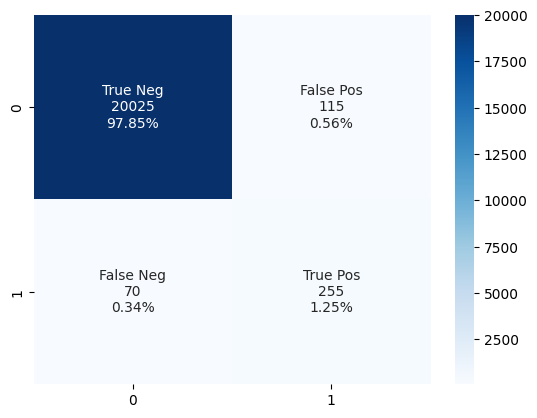

In [ ]:
# Confusion Matrix
Y_predict = OptimDtc.predict(X_test)
cf_matrix = confusion_matrix(Y_test,Y_predict)
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Creating the labels
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Print Confusion matrix
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

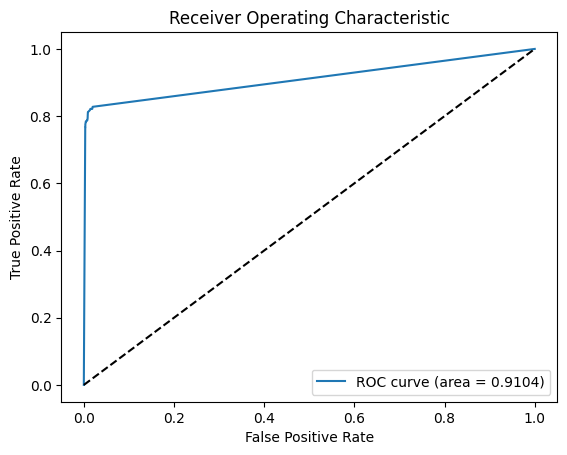

In [ ]:
# ROC Receiver operating Characteristic
Y_probs = OptimDtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)
roc_auc = auc(fpr, tpr)
# Traccia la curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linea di riferimento per una classificazione casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Unione dei due DataFrame
train_orig = pd.concat([train, original])
X_train_orig_cleaned,Y_train_orig_cleaned = cleaningAndEncoding(train_orig,'train_orig')


Missing values found in the dataframe.
Dropped 0 rows in the dataframe train_orig
No duplicate rows found in the dataframe train_orig.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#DecisionTreeClassifier

# Dividing Train and Set
X_train, X_test, Y_train, Y_test = train_test_split(X_train_orig_cleaned, Y_train_orig_cleaned, train_size = 0.85, random_state=42)
# Define the hyperparameters to tune
grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create an instance of the DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11)

# Create GridSearchCV object with the classifier and hyperparameter grid
Hyperparameter = GridSearchCV(estimator = dtc,
                              param_grid = grid,
                              cv = 5,
                              scoring = 'roc_auc')

# Fit the GridSearchCV object to the training data
Hyperparameter.fit(X_train, Y_train)

# Creating the optimum DTC
# OptimDtc = Hyperparameter.best_estimator_
OptimDtc = DecisionTreeClassifier(criterion = Hyperparameter.best_params_['criterion'],
               max_depth = Hyperparameter.best_params_['max_depth'],
               min_samples_split = Hyperparameter.best_params_['min_samples_split'],
               min_samples_leaf = Hyperparameter.best_params_['min_samples_leaf'],
               )

OptimDtc.fit(X_train,Y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", Hyperparameter.best_params_)
print("Best Roc_auc accuracy", Hyperparameter.best_score_)
print("-------------------------------------")
print("Test Accuracy:", OptimDtc.score(X_test, Y_test))

# Adding just the fault

<ipython-input-38-dd6ea68c80ba>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = train.append(selected_rows, ignore_index=True)


No missing values found in the dataframe train_originalFault.
Number of duplicate rows found in the dataframe train_originalFault: 1156.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(136768, 12)
(136768,)


train_origFault_cleaned

Total number of istances ended WELL 134281
Total number of istances ended FAIL 2487

Total istances: 136768


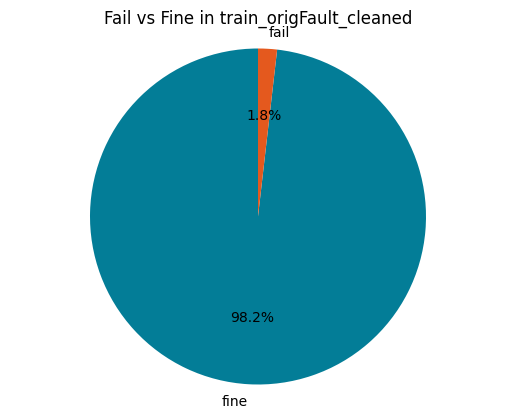

In [ ]:
# Selecting the fault from the orig file
selected_rows = original.loc[original['Machine failure'] == 1]

selected_rows = selected_rows.drop(columns='UDI', inplace=False)
merged_df = train.append(selected_rows, ignore_index=True)


X_train_origFault_cleaned,Y_train_origFault_cleaned = cleaningAndEncoding(merged_df,'train_originalFault')
train_origFault_cleaned = np.concatenate((X_train_origFault_cleaned,Y_train_origFault_cleaned.reshape(-1,1)), axis=1)

#train_OverBalanced = np.concatenate((X_train_over_balanced, Y_train_over_balanced.reshape(-1, 1)), axis=1)

print(X_train_origFault_cleaned.shape)
print(Y_train_origFault_cleaned.shape)

train_origFault_cleaned = pd.DataFrame(train_origFault_cleaned)

piechart(train_origFault_cleaned,'train_origFault_cleaned')
#ok

In [ ]:
#DecisionTreeClassifier

# Dividing Train and Set
X_train, X_test, Y_train, Y_test = train_test_split(X_train_origFault_cleaned, Y_train_origFault_cleaned, train_size = 0.85, random_state=42)
# Define the hyperparameters to tune
grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create an instance of the DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11)

# Create GridSearchCV object with the classifier and hyperparameter grid
Hyperparameter = GridSearchCV(estimator = dtc,
                              param_grid = grid,
                              cv = 5,
                              scoring = 'roc_auc')

# Fit the GridSearchCV object to the training data
Hyperparameter.fit(X_train, Y_train)

# Creating the optimum DTC
# OptimDtc = Hyperparameter.best_estimator_
OptimDtc = DecisionTreeClassifier(criterion = Hyperparameter.best_params_['criterion'],
               max_depth = Hyperparameter.best_params_['max_depth'],
               min_samples_split = Hyperparameter.best_params_['min_samples_split'],
               min_samples_leaf = Hyperparameter.best_params_['min_samples_leaf'],
               )

OptimDtc.fit(X_train,Y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", Hyperparameter.best_params_)
print("Best Roc_auc accuracy", Hyperparameter.best_score_)
print("-------------------------------------")
print("Test Accuracy:", OptimDtc.score(X_test, Y_test))

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Roc_auc accuracy 0.9434765847550317
-------------------------------------
Test Accuracy: 0.9954669526223435


<Axes: >

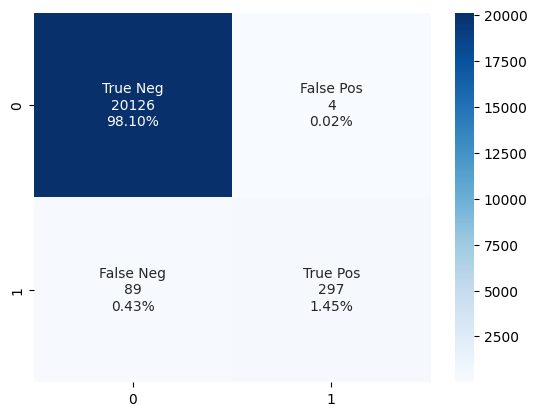

In [ ]:
# Confusion Matrix
Y_predict = OptimDtc.predict(X_test)
cf_matrix = confusion_matrix(Y_test,Y_predict)
group_names = ['True Neg','False Pos','False Neg','True Pos']

# Creating the labels
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Print Confusion matrix
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')